CNC MILLING DATASET - UNIVERSITY OF MICHIGAN SMART LAB

April 2018

A series of machining experiments were run on 2" x 2" x 1.5" wax blocks in a CNC milling machine in the System-level Manufacturing and Automation Research Testbed (SMART) at the University of Michigan. Machining data was collected from a CNC machine for variations of tool condition, feed rate, and clamping pressure. Each experiment produced a finished wax part with an "S" shape - S for smart manufacturing - carved into the top face, as shown in test_artifact.jpg


The dataset can be used in classification studies such as:

(1) Tool wear detection
Supervised binary classification could be performed for identification of worn and unworn cutting tools. Eight experiments were run with an unworn tool while ten were run with a worn tool (see tool_condition column for indication).

(2) Detection of inadequate clamping
The data could be used to detect when a workpiece is not being held in the vise with sufficient pressure to pass visual inspection (see passed_visual_inspection column for indication of visual flaws). Experiments were run with pressures of 2.5, 3.0, and 4.0 bar. The data could also be used for detecting when conditions are critical enough to prevent the machining operation from completing (see machining_completed column for indication of when machining was preemptively stopped due to safety concerns).


General data from a total of 18 different experiments are given in train.csv and includes:

Inputs (features)

No : experiment number
material : wax
feed_rate : relative velocity of the cutting tool along the workpiece (mm/s)
clamp_pressure : pressure used to hold the workpiece in the vise (bar)

Outputs (predictions)

tool_condition : label for unworn and worn tools
machining_completed : indicator for if machining was completed without the workpiece moving out of the pneumatic vise
passed_visual_inspection: indicator for if the workpiece passed visual inspection, only available for experiments where machining was completed


Time series data was collected from 18 experiments with a sampling rate of 100 ms and are separately reported in files experiment_01.csv to experiment_18.csv. Each file has measurements from the 4 motors in the CNC (X, Y, Z axes and spindle). These CNC measurements can be used in two ways:

(1) Taking every CNC measurement as an independent observation where the operation being performed is given in the Machining_Process column. Active machining operations are labeled as "Layer 1 Up", "Layer 1 Down", "Layer 2 Up", "Layer 2 Down", "Layer 3 Up", and "Layer 3 Down". 

(2) Taking each one of the 18 experiments (the entire time series) as an observation for time series classification


The features available in the machining datasets are:

X1_ActualPosition: actual x position of part (mm)
X1_ActualVelocity: actual x velocity of part (mm/s)
X1_ActualAcceleration: actual x acceleration of part (mm/s/s)
X1_CommandPosition: reference x position of part (mm)
X1_CommandVelocity: reference x velocity of part (mm/s)
X1_CommandAcceleration: reference x acceleration of part (mm/s/s)
X1_CurrentFeedback: current (A)
X1_DCBusVoltage: voltage (V)
X1_OutputCurrent: current (A)
X1_OutputVoltage: voltage (V)
X1_OutputPower: power (kW)

Y1_ActualPosition: actual y position of part (mm)
Y1_ActualVelocity: actual y velocity of part (mm/s)
Y1_ActualAcceleration: actual y acceleration of part (mm/s/s)
Y1_CommandPosition: reference y position of part (mm)
Y1_CommandVelocity: reference y velocity of part (mm/s)
Y1_CommandAcceleration: reference y acceleration of part (mm/s/s)
Y1_CurrentFeedback: current (A)
Y1_DCBusVoltage: voltage (V)
Y1_OutputCurrent: current (A)
Y1_OutputVoltage: voltage (V)
Y1_OutputPower: power (kW)

Z1_ActualPosition: actual z position of part (mm)
Z1_ActualVelocity: actual z velocity of part (mm/s)
Z1_ActualAcceleration: actual z acceleration of part (mm/s/s)
Z1_CommandPosition: reference z position of part (mm)
Z1_CommandVelocity: reference z velocity of part (mm/s)
Z1_CommandAcceleration: reference z acceleration of part (mm/s/s)
Z1_CurrentFeedback: current (A)
Z1_DCBusVoltage: voltage (V)
Z1_OutputCurrent: current (A)
Z1_OutputVoltage: voltage (V)

S1_ActualPosition: actual position of spindle (mm)
S1_ActualVelocity: actual velocity of spindle (mm/s)
S1_ActualAcceleration: actual acceleration of spindle (mm/s/s)
S1_CommandPosition: reference position of spindle (mm)
S1_CommandVelocity: reference velocity of spindle (mm/s)
S1_CommandAcceleration: reference acceleration of spindle (mm/s/s)
S1_CurrentFeedback: current (A)
S1_DCBusVoltage: voltage (V)
S1_OutputCurrent: current (A)
S1_OutputVoltage: voltage (V)
S1_OutputPower: current (A)
S1_SystemInertia: torque inertia (kg*m^2)

M1_CURRENT_PROGRAM_NUMBER: number the program is listed under on the CNC
M1_sequence_number: line of G-code being executed
M1_CURRENT_FEEDRATE: instantaneous feed rate of spindle

Machining_Process: the current machining stage being performed. Includes preparation, tracing up  and down the "S" curve involving different layers, and repositioning of the spindle as it moves through the air to a certain starting point

Installation of Necessary Libraries

In [2]:
!pip install xgboost

     --------------------------------------- 70.9/70.9 MB 10.4 MB/s eta 0:00:00


In [3]:
#Import the necessary Libraries.
import matplotlib
import pandas as pd
import matplotlib as plt
import seaborn as sns
from jedi.api.refactoring import inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables

In [23]:
#Creation of Dataframe

frames = list()
results = pd.read_csv("train.csv")
for i in range(1,19):
    exp = '0' + str(i) if i < 10 else str(i)
    frame = pd.read_csv("experiment_{}.csv".format(exp))
    row = results[results['No'] == i]
    frame['target'] = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0
    frames.append(frame)
df = pd.concat(frames, ignore_index = True)
df.head()

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_DCBusVoltage,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,target
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,2.740000e-19,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,Starting,0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,2.740000e-19,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,Prep,0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,2.740000e-19,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,Prep,0
3,194.0,-18.0,0.00,194.0,-17.9,-0.000095,-6.11,0.1300,327.0,30.30,...,2.740000e-19,328.0,0.0,1.070000e-06,12.0,1.0,7.0,50.0,Prep,0
4,193.0,-17.9,-18.80,192.0,-17.9,0.000095,-5.70,0.1140,328.0,30.50,...,2.740000e-19,328.0,0.0,1.960000e-06,12.0,1.0,7.0,50.0,Prep,0


1. `frames = list()`: This initializes an empty list called `frames`.
2. `results = pd.read_csv("train.csv")`: It reads data from a CSV file named "train.csv" and stores it in the `results` DataFrame.
3. The following loop iterates from 1 to 18 (exclusive) using `i` as the loop variable.
4. `exp = '0' + str(i) if i < 10 else str(i)`: This line creates a string variable `exp` with a leading '0' if `i` is less than 10, otherwise, it directly converts `i` to a string. This is used to generate the filenames of the other CSV files, such as "experiment_01.csv", "experiment_02.csv", ..., "experiment_18.csv".
5. `frame = pd.read_csv("experiment_{}.csv".format(exp))`: It reads data from a CSV file with the name "experiment_{}.csv" using the `exp` variable to replace the `{}` placeholder. This will load data from different files in each iteration of the loop and store it in the `frame` DataFrame.
6. `row = results[results['No'] == i]`: This line filters the `results` DataFrame to find the row where the column 'No' has the value equal to `i`.
7. `frame['target'] = 1 if row.iloc[0]['tool_condition'] == 'worn' else 0`: It adds a new column called 'target' to the `frame` DataFrame and assigns a value of 1 if the corresponding row in the `results` DataFrame has the 'tool_condition' equal to 'worn', otherwise, it assigns 0.
8. `frames.append(frame)`: The `frame` DataFrame is added to the `frames` list in each iteration.
9. After the loop, `pd.concat(frames, ignore_index=True)` concatenates all the DataFrames in the `frames` list into a single DataFrame called `df`, ignoring the original index of each DataFrame and creating a new index.
10. `df.head()`: Finally, `df.head()` displays the first few rows of the merged DataFrame.
So, the code reads data from multiple CSV files, adds a new column 'target' to each DataFrame indicating whether the 'tool_condition' is 'worn' (1) or not (0), and then concatenates all the DataFrames into a single DataFrame named `df`. The `df.head()` function call displays the first few rows of this merged DataFrame.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25286 entries, 0 to 25285
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X1_ActualPosition          25286 non-null  float64
 1   X1_ActualVelocity          25286 non-null  float64
 2   X1_ActualAcceleration      25286 non-null  float64
 3   X1_CommandPosition         25286 non-null  float64
 4   X1_CommandVelocity         25286 non-null  float64
 5   X1_CommandAcceleration     25286 non-null  float64
 6   X1_CurrentFeedback         25286 non-null  float64
 7   X1_DCBusVoltage            25286 non-null  float64
 8   X1_OutputCurrent           25286 non-null  float64
 9   X1_OutputVoltage           25286 non-null  float64
 10  X1_OutputPower             25286 non-null  float64
 11  Y1_ActualPosition          25286 non-null  float64
 12  Y1_ActualVelocity          25286 non-null  float64
 13  Y1_ActualAcceleration      25286 non-null  flo

Data Visualization

C:\Users\gaura\AppData\Local\Temp\ipykernel_26904\3092581622.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_correlation=df.corr()


<Axes: >

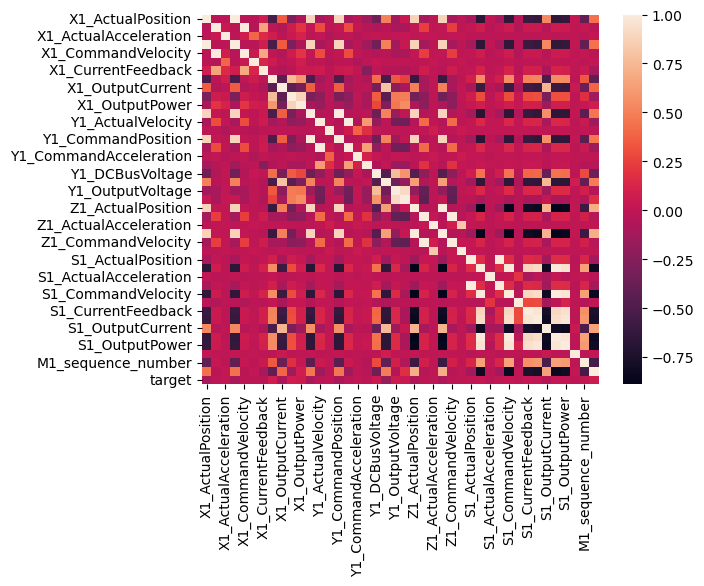

In [14]:
df_correlation=df.corr()
df_correlation.dropna(thresh=1,inplace=True)
df_correlation.drop(columns=['Z1_CurrentFeedback','Z1_DCBusVoltage','Z1_OutputCurrent','Z1_OutputVoltage','S1_SystemInertia','target'],inplace=True)
sns.heatmap(df_correlation)

Conclusion of correlation analysis
It has been found that there are no significant correlations between target and other variables, this is mainly because there is no linear relationship which implies a non linear model

In [60]:
#Creating Test Train Splits
x=df.drop(columns=['target','Machining_Process'],axis=1)
y=np.array(df['target'])

X_train,X_test,y_train,y_test =train_test_split(x,y,train_size=0.8,random_state=0)

In [61]:
classifier = LogisticRegression(random_state = 5, max_iter=10000 )
classifier.fit(X_train, y_train)
y_pred_1 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_1)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix(y_test, y_pred_1)
print(cnf_matrix)

Accuracy: 58.03%
[[1178 1214]
 [ 909 1757]]


In [49]:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)
y_pred_2 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_2)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix(y_test, y_pred_2)
print(cnf_matrix)

Accuracy: 58.19%
[[ 834 1585]
 [ 530 2109]]


In [38]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred_3 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_3)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix(y_test, y_pred_3)
print(cnf_matrix)

Accuracy: 54.61%
[[ 536 1883]
 [ 413 2226]]


In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred_4 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_4)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix(y_test, y_pred_4)
print(cnf_matrix)

Accuracy: 76.02%
[[1816  603]
 [ 610 2029]]


In [54]:
classifier = DecisionTreeClassifier(max_depth=7)
classifier.fit(X_train, y_train)
y_pred_5 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_5)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix( y_test, y_pred_5)
print(cnf_matrix)

Accuracy: 87.31%
[[1785  634]
 [   8 2631]]


In [44]:
from sklearn.ensemble import RandomForestClassifier as RFC
classifier=RFC(n_estimators=100,criterion='entropy',random_state=0)

classifier.fit(X_train, y_train)
y_pred_6 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_6)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix(y_test, y_pred_6)
print(cnf_matrix)

Accuracy: 99.35%
[[2399   20]
 [  13 2626]]


In [45]:
classifier=XGBClassifier()
classifier.fit(X_train,y_train)
y_pred_7 = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred_7)
print("Accuracy: %.2f%%" % (acc * 100.0))
cnf_matrix = confusion_matrix(y_test, y_pred_7)
print(cnf_matrix)

Accuracy: 99.53%
[[2405   14]
 [  10 2629]]


In [59]:
# Feature importances
features = [(df.columns[i], v) for i,v in enumerate(classifier.feature_importances_)]
features.sort(key=lambda x: x[1], reverse = True)
for item in features[:15]:
    print("{0}: {1:0.4f}".format(item[0], item[1]))

Z1_ActualPosition: 0.8164
Z1_CommandPosition: 0.1285
Y1_OutputCurrent: 0.0503
Z1_CommandVelocity: 0.0017
S1_OutputCurrent: 0.0007
S1_OutputPower: 0.0006
X1_ActualAcceleration: 0.0006
Z1_ActualVelocity: 0.0005
Z1_ActualAcceleration: 0.0003
X1_DCBusVoltage: 0.0002
Y1_OutputPower: 0.0002
X1_ActualPosition: 0.0000
X1_ActualVelocity: 0.0000
X1_CommandPosition: 0.0000
X1_CommandVelocity: 0.0000


In [51]:
#Ensembeling
from statistics import mode
from scipy import stats as s

final_pred = np.array([])
for i in range(0, len(X_test)):
    final_pred = np.append(final_pred, s.mode([y_pred_7[i], y_pred_7[i], y_pred_7[i], y_pred_6[i], y_pred_6[i], y_pred_5[i], y_pred_5[i]], keepdims=False)[0])

c = accuracy_score(y_test, final_pred)
print("Accuracy: %.2f%%" % (c * 100.0))
cnf_matrix = confusion_matrix(y_test, final_pred)
print(cnf_matrix)

Accuracy: 99.39%
[[2396   23]
 [   8 2631]]
